# **Deep Learning Lab: Transfer Learning**

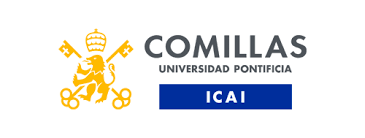

***

## Import packages

In [10]:
from cnn import CNN
import torchvision
from cnn import load_data
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import wandb

## Model and data loading

In [11]:
import wandb

# Inicializar experimento en W&B
wandb.init(
    project="image-classification-prueba",
    name="ResNet101_last2layers_20epoch_lr1e-4weightdecay1e-6",
    config={
        "batch_size": 32,
        "img_size":256,
        "epochs": 20,  # permitimos hasta 50 con early stopping
        "learning_rate": 1e-3,  # menor LR
        "weight_decay": 1e-5,
        "patience": 10
    },
    tags=["finetune", "resnet50", "earlystop"]
)


config = dict(wandb.config)
print("Parámetros del experimento:", config)



Parámetros del experimento: {'batch_size': 32, 'img_size': 256, 'epochs': 20, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'patience': 5}


In [12]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [13]:
from cnn import CNN, load_data
import torchvision
import torch
import torch.nn as nn

# Carga de datos
train_dir = r'C:\Users\Usuario\ML_PROJECY\dataset\dataset\training'
valid_dir = r'C:\Users\Usuario\ML_PROJECY\dataset\dataset\validation'

train_loader, valid_loader, num_classes = load_data(train_dir, valid_dir, batch_size=config["batch_size"], img_size=config["img_size"])

# Cargar modelo y descongelar últimas capas
resnet = torchvision.models.resnet101(weights='DEFAULT')


model = CNN(resnet, num_classes, 3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


print("Capas entrenables:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)



Capas entrenables:
base_model.layer4.0.conv1.weight
base_model.layer4.0.bn1.weight
base_model.layer4.0.bn1.bias
base_model.layer4.0.conv2.weight
base_model.layer4.0.bn2.weight
base_model.layer4.0.bn2.bias
base_model.layer4.0.conv3.weight
base_model.layer4.0.bn3.weight
base_model.layer4.0.bn3.bias
base_model.layer4.0.downsample.0.weight
base_model.layer4.0.downsample.1.weight
base_model.layer4.0.downsample.1.bias
base_model.layer4.1.conv1.weight
base_model.layer4.1.bn1.weight
base_model.layer4.1.bn1.bias
base_model.layer4.1.conv2.weight
base_model.layer4.1.bn2.weight
base_model.layer4.1.bn2.bias
base_model.layer4.1.conv3.weight
base_model.layer4.1.bn3.weight
base_model.layer4.1.bn3.bias
base_model.layer4.2.conv1.weight
base_model.layer4.2.bn1.weight
base_model.layer4.2.bn1.bias
base_model.layer4.2.conv2.weight
base_model.layer4.2.bn2.weight
base_model.layer4.2.bn2.bias
base_model.layer4.2.conv3.weight
base_model.layer4.2.bn3.weight
base_model.layer4.2.bn3.bias
fc.0.weight
fc.0.bias
fc.3

In [14]:
print(torch.cuda.get_device_name(0))  # Nombre de tu GPU

NVIDIA GeForce GTX 1050


In [15]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

def validate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / total, correct / total, all_preds, all_labels


In [16]:
# Setup entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=config["learning_rate"],
                             weight_decay=config["weight_decay"])


# Early stopping
best_val_acc = 0
epochs_no_improve = 0
patience = config["patience"]

for epoch in range(config["epochs"]):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_preds, val_labels = validate(model, valid_loader, criterion)

   

    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "lr": optimizer.param_groups[0]['lr']
    })

    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            y_true=val_labels,
            preds=val_preds,
            class_names=train_loader.dataset.classes
        )
    })

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        # Guardar mejor modelo
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping activado tras {patience} épocas sin mejora.")
            break


Epoch 1: Train Acc: 0.6409 | Val Acc: 0.8607
Epoch 2: Train Acc: 0.7889 | Val Acc: 0.8787
Epoch 3: Train Acc: 0.8161 | Val Acc: 0.8833
Epoch 4: Train Acc: 0.8399 | Val Acc: 0.8967
Epoch 5: Train Acc: 0.8436 | Val Acc: 0.9193
Epoch 6: Train Acc: 0.8667 | Val Acc: 0.9333
Epoch 7: Train Acc: 0.8744 | Val Acc: 0.9287
Epoch 8: Train Acc: 0.8720 | Val Acc: 0.9293
Epoch 9: Train Acc: 0.8764 | Val Acc: 0.9127
Epoch 10: Train Acc: 0.8938 | Val Acc: 0.8940
Epoch 11: Train Acc: 0.8884 | Val Acc: 0.9193
Early stopping activado tras 5 épocas sin mejora.


In [69]:
import random
import torchvision

# Log predicciones
def log_predictions(model, dataloader, classnames):
    model.eval()
    images_to_log = []
    indices = random.sample(range(len(dataloader.dataset)), 4)
    for i in indices:
        img, label = dataloader.dataset[i]
        input_tensor = img.unsqueeze(0).to(device)
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        images_to_log.append(wandb.Image(img, caption=f"True: {classnames[label]} | Pred: {classnames[pred.item()]}"))
    wandb.log({"sample_predictions": images_to_log})

log_predictions(model, valid_loader, train_loader.dataset.classes)


In [70]:
# Guardar con nombre dinámico
model_name = f"resnet50_finetune_bs{config["batch_size"]}_lr{config["learning_rate"]}.pth"
torch.save(model.state_dict(), model_name)

# Subir a W&B como artifact (seguro para Windows)
artifact = wandb.Artifact(model_name, type="model")
artifact.add_file(model_name)
wandb.log_artifact(artifact)

# Finalizar experimento
wandb.finish()


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
lr,████████████▁
train_accuracy,▁▅▅▆▆▆▇▇▇█▇██
train_loss,█▄▄▃▃▃▂▂▁▁▂▁▁
val_accuracy,▂▁▂▃▅▅▅▇▇████
val_loss,▇█▇▆▄▄▄▁▂▁▁▁▁
epoch,13
lr,0.0005
train_accuracy,0.68308
train_loss,2.13348
val_accuracy,0.72867


In [71]:
wandb.finish()

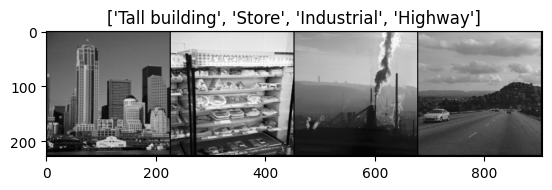

In [9]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])
wandb.log({"sample_images": [wandb.Image(out, caption="Sample Images")]})


## Train

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Entrenar el modelo y registrar métricas en W&B
for epoch in range(1):  # Solo 1 época en este caso
    history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=1)
    
    # Registrar métricas en W&B
    for epoch_data in history:
        wandb.log({
            "train_loss": history["train_loss"][0],  # Tomamos el primer (y único) valor de la lista
            "valid_loss": history["valid_loss"][0],
            "train_acc": history["train_accuracy"][0],
            "valid_acc": history["valid_accuracy"][0]
        })


Epoch 1/1 - Train Loss: 2.6396, Train Accuracy: 0.2814
Epoch 1/1 - Validation Loss: 2.5319, Validation Accuracy: 0.4107


In [11]:
model.save_model('resnet50-1epoch')

## Predict

#### Load model

In [12]:
# Load model
model_weights = load_model_weights('resnet50-1epoch')
my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

<All keys matched successfully>

## Results

In [13]:
predicted_labels = my_trained_model.predict(valid_loader)

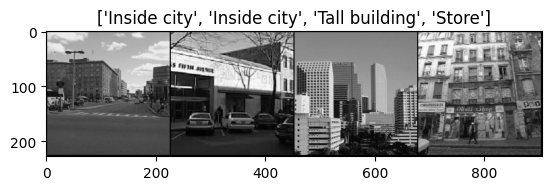

In [14]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])
wandb.log({"predicted_images": [wandb.Image(out, caption="Predicted Images")]})



In [15]:
wandb.finish()

train_acc,▁▁▁▁
train_loss,▁▁▁▁
valid_acc,▁▁▁▁
valid_loss,▁▁▁▁
train_acc,0.28141
train_loss,2.63961
valid_acc,0.41067
valid_loss,2.53186
